<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/vitalfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vital 파일 다루기
Vital Recorder 에서 생성한 Vital 파일을 파이선으로 읽어오는 방법을 알아보겠습니다.

## 샘플 vital 파일 다운로드
아래 코드를 실행하여 vitaldb 의 샘플 vital 파일을 다운로드 합니다.

In [5]:
!wget -N https://vitaldb.net/samples/00001.vital

--2021-08-27 23:34:22--  https://vitaldb.net/samples/00001.vital
Resolving vitaldb.net (vitaldb.net)... 3.37.69.87, 3.36.161.141
Connecting to vitaldb.net (vitaldb.net)|3.37.69.87|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘00001.vital’ not modified on server. Omitting download.



## Vital 파일을 읽기 위한 라이브러리 다운로드

github에 공개된 vitaldb 라이브러리를 이용합니다.

In [6]:
!pip install vitaldb

vitaldb 라이브러리에서 vital 파일을 읽기 위한 utils 모듈을 import 합니다.

In [2]:
import vitaldb

## Vital 파일 트랙 목록 읽기
vital_trks 함수를 사용하여 개인이 보유한 vital 파일을 내용을 읽습니다.

In [3]:
trks = vitaldb.vital_trks('00001.vital')
trks

['/EVENT',
 'SNUADC/ART',
 'SNUADC/ECG_II',
 'SNUADC/ECG_V5',
 'SNUADC/PLETH',
 'Solar 8000M/HR',
 'Solar 8000M/ST_I',
 'Solar 8000M/ST_II',
 'Solar 8000M/ST_III',
 'Solar 8000M/ST_AVL',
 'Solar 8000M/ST_AVR',
 'Solar 8000M/ST_AVF',
 'Solar 8000M/ART_MBP',
 'Solar 8000M/ART_SBP',
 'Solar 8000M/ART_DBP',
 'Solar 8000M/PLETH_SPO2',
 'Solar 8000M/PLETH_HR',
 'Solar 8000M/BT',
 'Solar 8000M/VENT_MAWP',
 'Solar 8000M/ST_V5',
 'Solar 8000M/NIBP_MBP',
 'Solar 8000M/NIBP_SBP',
 'Solar 8000M/NIBP_DBP',
 'Solar 8000M/VENT_PIP',
 'Solar 8000M/VENT_RR',
 'Solar 8000M/VENT_MV',
 'Solar 8000M/VENT_TV',
 'Solar 8000M/VENT_PPLAT',
 'Solar 8000M/GAS2_AGENT',
 'Solar 8000M/GAS2_EXPIRED',
 'Solar 8000M/GAS2_INSPIRED',
 'Solar 8000M/ETCO2',
 'Solar 8000M/INCO2',
 'Solar 8000M/RR_CO2',
 'Solar 8000M/FEO2',
 'Solar 8000M/FIO2',
 'Solar 8000M/VENT_INSP_TM',
 'Solar 8000M/VENT_SET_TV',
 'Solar 8000M/VENT_SET_PCP',
 'Primus/CO2',
 'Primus/AWP',
 'Primus/INSP_SEVO',
 'Primus/EXP_SEVO',
 'Primus/PAMB_MBAR',
 'Pr

## Vital 파일 내용 읽기
vital_recs 함수를 사용하여 개인이 보유한 vital 파일을 내용을 읽습니다.

In [4]:
vals = vitaldb.vital_recs('00001.vital', ['ECG_II','ART'], 1/100)
vals

array([[         nan,          nan],
       [         nan,          nan],
       [         nan,          nan],
       ...,
       [ -0.28558824, -12.75951172],
       [  0.16864199,  30.68859766],
       [  0.38588254, -16.70933984]])

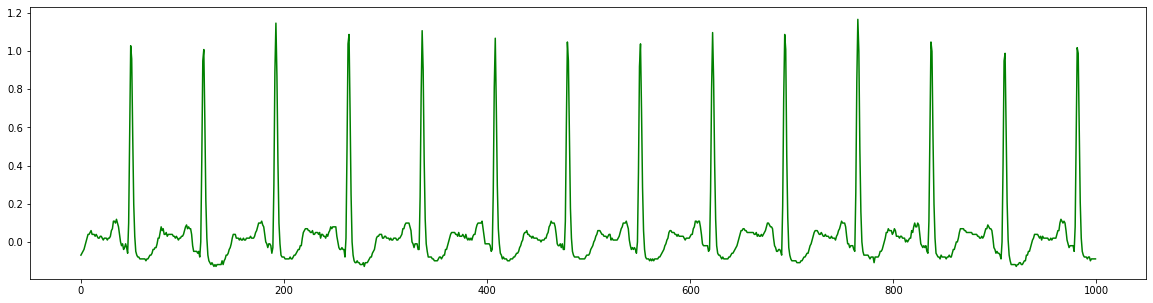

In [6]:
import matplotlib.pyplot as plt

# ecg 트랙을 그림
ecg = vals[:,0]
plt.figure(figsize=(20,5))
plt.plot(ecg[110000:111000], color='g')
plt.show()

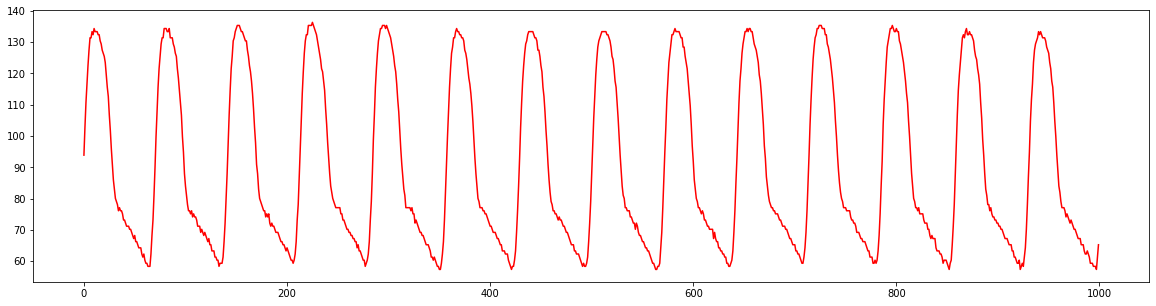

In [11]:
# 동맥압 파형을 그림
art = vals[:,1]
plt.figure(figsize=(20,5))
plt.plot(art[110000:111000], color='r')
plt.show()

# 생체 신호 처리 모듈 (pyvital) 이용

pyvital 의 모든 코드는 오픈 소스로 https://github.com/vitaldb/pyvital 에 공개 되어 있습니다.

In [1]:
!pip install pyvital

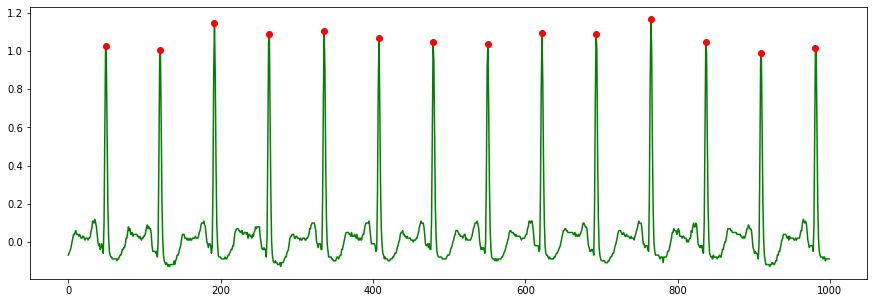

In [7]:
import pyvital

ecg = vals[110000:111000, 0]
ecg = pyvital.exclude_undefined(ecg)
peaks = pyvital.detect_qrs(ecg, 100)

plt.figure(figsize=(15,5))
plt.plot(ecg, color='g')
plt.plot(peaks, [ecg[i] for i in peaks], 'ro')
plt.show()

[[133, 206, 277, 350, 421, 491, 563, 635, 707, 777, 852, 922], [79, 151, 225, 294, 367, 438, 510, 582, 653, 724, 796, 869, 940]]


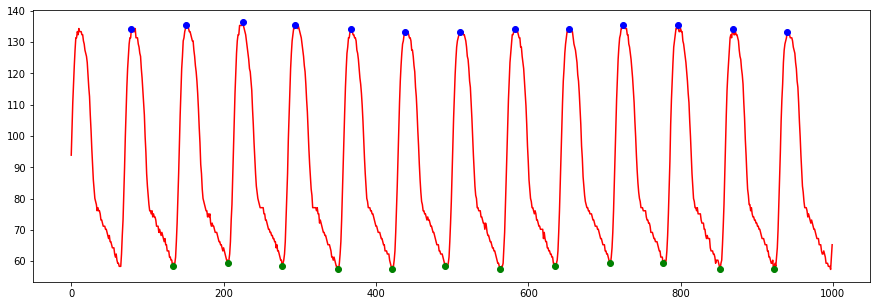

In [14]:
art = vals[110000:111000, 1]
art = pyvital.exclude_undefined(art)
peaks = pyvital.detect_peaks(art, 100)
print(peaks)

plt.figure(figsize=(15,5))
plt.plot(art, color='r')
plt.plot(peaks[0], [art[i] for i in peaks[0]], 'go')
plt.plot(peaks[1], [art[i] for i in peaks[1]], 'bo')
plt.show()

# Vital 파일을 읽어 필터를 적용하기
vital recorder 에서 사용하는 필터 함수를 적용해 봅시다. 본 예제에서는 상기 동맥압 파형을 이용하여 Pulse Pressure Variation (PPV)을 구해보겠습니다.

모든 필터는 cfg 라는 이름의 프로퍼티가 있습니다. 여기에는 입력값, 출력값에 대한 정의 및 reference 등이 있습니다. 우선, 그것부터 확인해 봅시다.

In [9]:
import pyvital.filters.abp_ppv as f
f.cfg

{'desc': 'Calculate pulse pressure variation using modified version of the method in the reference',
 'group': 'ABP',
 'inputs': [{'name': 'ART', 'type': 'wav'}],
 'interval': 30,
 'name': 'Pulse Pressure Variation',
 'outputs': [{'max': 30, 'min': 0, 'name': 'PPV', 'type': 'num', 'unit': '%'},
  {'max': 30, 'min': 0, 'name': 'SPV', 'type': 'num', 'unit': '%'},
  {'max': 30, 'min': 0, 'name': 'ART_RR', 'type': 'num', 'unit': '/min'}],
 'overlap': 20,
 'reference': 'Aboy et al, An Enhanced Automatic Algorithm for Estimation of Respiratory Variations in Arterial Pulse Pressure During Regions of Abrupt Hemodynamic Changes. IEEE TRANSACTIONS ON BIOMEDICAL ENGINEERING, VOL. 56, NO. 10, OCTOBER 2009'}

동맥압을 100Hz로 읽어 PPV 필터를 적용해 봅시다. 필터 모듈의 run 함수를 호출하면 됩니다.

In [12]:
art = vals[300000:306000, 1]

res = f.run({'ART':{'srate':100, 'vals':art}}, {}, f.cfg)
res[0]

[{'dt': 30, 'val': 3.5920580448081254}]